In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows = 500

In [3]:
import os
import sys

releasy_module = os.path.abspath(os.path.join('..','..','..','dev','releasy2'))
if releasy_module not in sys.path:
    sys.path.insert(0, releasy_module)
    
import releasy
from releasy.miner_git import GitVcs
from releasy.miner import TagReleaseMiner, PathCommitMiner, RangeCommitMiner, TimeCommitMiner, VersionReleaseMatcher, VersionReleaseSorter


In [4]:
projects = pd.read_pickle('projects.zip')

In [5]:
releases = pd.DataFrame(columns=[
    "project","name", "lang","commits",
    "range_commits", "range_tpos", "range_fpos","range_fneg",
    "time_commits", "time_tpos", "time_fpos","time_fneg"])
    
count = 0
for i,project in enumerate(projects.itertuples()):
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    
    try:
        print(f"{i+1:3} {project.name}")
        vcs = GitVcs(path)
        release_matcher = VersionReleaseMatcher()
        release_sorter = VersionReleaseSorter()
    
        release_miner = TagReleaseMiner(vcs, release_matcher, release_sorter)
        release_set = release_miner.mine_releases()

        path_miner = PathCommitMiner(vcs, release_set)
        range_miner = RangeCommitMiner(vcs, release_set)
        time_miner = TimeCommitMiner(vcs, release_set)
    
        print(f" - parsing by path")
        path_release_set = path_miner.mine_commits()
        print(f" - parsing by time")
        time_release_set = time_miner.mine_commits()
        print(f" - parsing by range")
        range_release_set = range_miner.mine_commits()
        
    
        stats = []
        for release in release_set:
            path_commits = set(path_release_set[release.name].commits)
            range_commits = set(range_release_set[release.name].commits)
            time_commits = set(time_release_set[release.name].commits)
    
            stats.append({
                "project": project.name,
                "name": release.name,
                "lang": project.lang,
                "commits": len(path_commits),
                "range_commits": len(range_commits),
                "range_tpos": len(path_commits & range_commits),
                "range_fpos": len(range_commits - path_commits),
                "range_fneg": len(path_commits - range_commits),
                "time_commits": len(time_commits),
                "time_tpos": len(path_commits & time_commits),
                "time_fpos": len(time_commits - path_commits),
                "time_fneg": len(path_commits - time_commits)
            })
        releases = releases.append(pd.DataFrame(stats))
    except Exception as e:
        print(f" - error: {e}")
    
releases_bkp = releases.copy()  

  1 vuejs/vue
 - parsing by path
 - parsing by time
 - parsing by range
  2 facebook/react
 - parsing by path
 - parsing by time
 - parsing by range
  3 twbs/bootstrap
 - parsing by path
 - parsing by time
 - parsing by range
  4 d3/d3
 - parsing by path
 - parsing by time
 - parsing by range
  5 facebook/react-native
 - parsing by path
 - parsing by time
 - parsing by range
  6 facebook/create-react-app
 - parsing by path
 - parsing by time
 - parsing by range
  7 nodejs/node
 - parsing by path
 - parsing by time
 - parsing by range
  8 mrdoob/three.js
 - parsing by path
 - parsing by time
 - parsing by range
  9 mui-org/material-ui
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\mui-org\material-ui
 10 angular/angular.js
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\angular\angular.js
 11 microsoft/vscode
 - error: Repository not found at C:\Users\felipecrp\Research\Release\repos2\microsoft\vscode
 12 denoland/deno
 - error:

In [181]:
# releases_bkp = releases.copy()
# releases = releases_bkp.copy()

In [6]:
releases = releases[releases.commits > 0].copy()

In [7]:
releases.commits = pd.to_numeric(releases.commits)
releases.range_commits = pd.to_numeric(releases.range_commits)
releases.range_tpos = pd.to_numeric(releases.range_tpos)
releases.range_fpos = pd.to_numeric(releases.range_fpos)
releases.range_fneg = pd.to_numeric(releases.range_fneg)
releases.time_commits = pd.to_numeric(releases.time_commits)
releases.time_tpos = pd.to_numeric(releases.time_tpos)
releases.time_fpos = pd.to_numeric(releases.time_fpos)
releases.time_fneg = pd.to_numeric(releases.time_fneg)

In [8]:
def precision(row, column):
    if row[column+"_tpos"] + row[column+"_fpos"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fpos"])
    
def recall(row, column):
    if row[column+"_tpos"] + row[column+"_fneg"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fneg"])


In [9]:
releases['range_precision'] = releases.apply(precision, args=('range',), axis=1)
releases['range_recall'] = releases.apply(recall, args=('range',), axis=1)
releases['time_precision'] = releases.apply(precision, args=('time',), axis=1)
releases['time_recall'] = releases.apply(recall, args=('time',), axis=1)

In [10]:
releases[releases['range_precision'] > 0.5].shape[0]

6372

In [11]:
releases[releases['time_recall'] < 1].shape

(3893, 16)

In [12]:
debug = False

p    rng  tme 


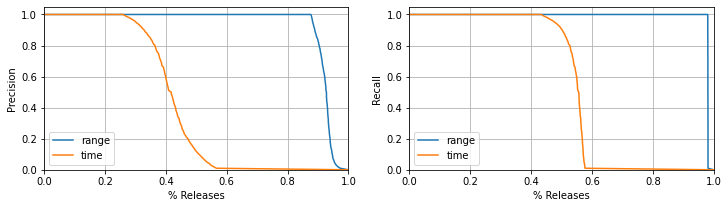

In [13]:
fig, (ap,ar) = plt.subplots(1,2)
fig.set_size_inches(12,3)
ap.set_xlabel("% Releases")
ap.set_ylabel("Precision")

ar.set_xlabel("% Releases")
ar.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_precision_range = []
x_precision_time = []
x_recall_range = []
x_recall_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_precision_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_precision_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    range_recall_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_recall_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_precision_range.append(range_precision_percent)
    x_precision_time.append(time_precision_percent)
    x_recall_range.append(range_recall_percent)
    x_recall_time.append(time_recall_percent)
    
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_precision_range[-1]:4.2f} {x_precision_time[-1]:4.2f} {x_recall_range[-1]:4.2f} {x_recall_time[-1]:4.2f}") if debug else None

y.append(1)
x_precision_range.append(0)
x_precision_time.append(0)
x_recall_range.append(0)
x_recall_time.append(0)
ap.plot(x_precision_range,y, label='range')
ap.plot(x_precision_time,y, label='time')
ap.legend(loc='lower left')
ap.set_xlim((0,1))
ap.set_ylim((0,1.05))
ap.xaxis.grid()
ap.yaxis.grid()

ar.plot(x_recall_range,y, label='range')
ar.plot(x_recall_time,y, label='time')
ar.legend(loc='lower left')
ar.set_xlim((0,1))
ar.set_ylim((0,1.05))
ar.xaxis.grid(which='both')
ar.yaxis.grid()

In [42]:
releases.shape

(6878, 16)

In [16]:
releases[releases.range_recall < 1].sort_values('range_recall', ascending=False).shape

(134, 16)

In [43]:
releases[releases.range_recall < 1]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
49,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.000000,0.000000,0.000000,0.000000
52,vuejs/vue,0.12.1-csp.2,javascript,20,17,17,0,3,3,3,0,17,1.000000,0.850000,1.000000,0.150000
54,vuejs/vue,0.12.1,javascript,10,0,0,0,10,0,0,0,10,0.000000,0.000000,0.000000,0.000000
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.000000,0.000000,0.000000,0.000000
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.000000,0.000000,0.000000,0.000000
64,vuejs/vue,0.12.8,javascript,32,0,0,0,32,0,0,0,32,0.000000,0.000000,0.000000,0.000000
66,vuejs/vue,0.12.9,javascript,24,0,0,0,24,0,0,0,24,0.000000,0.000000,0.000000,0.000000
68,vuejs/vue,0.12.10,javascript,29,0,0,0,29,0,0,0,29,0.000000,0.000000,0.000000,0.000000
70,vuejs/vue,0.12.11,javascript,53,0,0,0,53,0,0,0,53,0.000000,0.000000,0.000000,0.000000
72,vuejs/vue,0.12.12,javascript,2,0,0,0,2,0,0,0,2,0.000000,0.000000,0.000000,0.000000


In [21]:
releases.sort_values('range_recall', ascending=False)

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,vuejs/vue,0.6.0,javascript,354,354,354,0,0,354,354,0,0,1.000000,1.0,1.0,1.0
419,laravel/framework,v5.8.26,php,3,3,3,0,0,0,0,0,3,1.000000,1.0,0.0,0.0
443,laravel/framework,v6.5.1,php,22,22,22,0,0,0,0,0,22,1.000000,1.0,0.0,0.0
442,laravel/framework,v6.5.0,php,16,16,16,0,0,0,0,0,16,1.000000,1.0,0.0,0.0
441,laravel/framework,v6.4.1,php,22,23,22,1,0,0,0,0,22,0.956522,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,facebook/react,v0.10.0-rc1,javascript,1,0,0,0,1,0,0,0,1,0.000000,0.0,0.0,0.0
19,facebook/react,v0.11.0-rc1,javascript,4,0,0,0,4,0,0,0,4,0.000000,0.0,0.0,0.0
55,protocolbuffers/protobuf,v3.7.0-rc.2,c++,6,0,0,0,6,0,0,0,6,0.000000,0.0,0.0,0.0
97,facebook/react-native,v0.28.0-rc.0,javascript,182,0,0,0,182,0,0,0,182,0.000000,0.0,0.0,0.0


<AxesSubplot:>

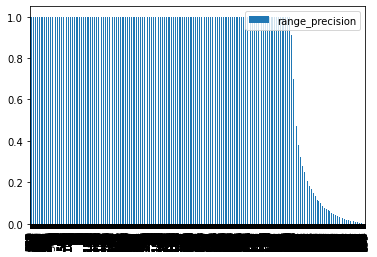

In [267]:
# fig, (ax) = plt.subplots()
# releases.sort_values('range_precision', ascending=False).plot.bar(y='range_precision', ax=ax)


1) Ordenar as releases - ordenando por data
 - path - data
 - time - data
 - range - data / version **

In [19]:
releases[releases.range_precision <= 0.001]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
49,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.000000,0.0,0.000000,0.0
54,vuejs/vue,0.12.1,javascript,10,0,0,0,10,0,0,0,10,0.000000,0.0,0.000000,0.0
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.000000,0.0,0.000000,0.0
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.000000,0.0,0.000000,0.0
64,vuejs/vue,0.12.8,javascript,32,0,0,0,32,0,0,0,32,0.000000,0.0,0.000000,0.0
66,vuejs/vue,0.12.9,javascript,24,0,0,0,24,0,0,0,24,0.000000,0.0,0.000000,0.0
68,vuejs/vue,0.12.10,javascript,29,0,0,0,29,0,0,0,29,0.000000,0.0,0.000000,0.0
70,vuejs/vue,0.12.11,javascript,53,0,0,0,53,0,0,0,53,0.000000,0.0,0.000000,0.0
72,vuejs/vue,0.12.12,javascript,2,0,0,0,2,0,0,0,2,0.000000,0.0,0.000000,0.0
75,vuejs/vue,0.12.14,javascript,13,0,0,0,13,0,0,0,13,0.000000,0.0,0.000000,0.0


In [204]:
releases.iloc[51]

project             vuejs/vue
name                   0.12.1
lang               javascript
commits                    13
range_commits              13
range_tpos                 13
range_fpos                  0
range_fneg                  0
time_commits               11
time_tpos                  10
time_fpos                   1
time_fneg                   3
range_precision             1
range_recall                1
time_precision       0.909091
time_recall          0.769231
Name: 51, dtype: object

p    rng  tme 


(0.0, 1.05)

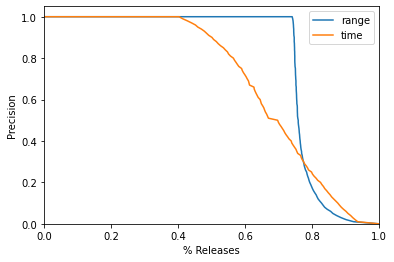

In [147]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Precision")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))


p    rng  tme 


(0.0, 1.05)

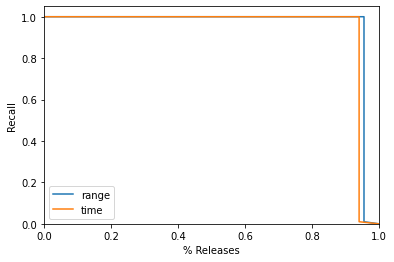

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))
    


## Overall

https://stackoverflow.com/questions/43592279/difference-between-aggregate-precision-recall-curves-and-precision-recall-curves#:~:text=You%20typically%20create%20a%20precision,you%20can%20plot%20this%20curve.&text=They%20are%20referring%20to%20this,recall%20curves%20in%20this%20work.

In [21]:
overall = pd.DataFrame(releases.mean()).transpose()
overall

,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,77.987496,101.467723,74.741495,26.726229,3.246002,78.052922,32.228409,45.824513,45.759087,0.92286,0.981075,0.41651,0.544941


,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,vuejs/vuevuejs/vuevuejs/vuevuejs/vuevuejs/vuev...,0.6.0v0.7.0v0.7.1v0.7.2v0.7.3v0.7.4v0.7.5v0.7....,javascriptjavascriptjavascriptjavascriptjavasc...,536398,2256283,536398,1719885,0,536803,344880,191923,191518,0.237735,1.0,0.64247,0.642955


## Per project

In [38]:
rproj = releases.groupby(['project']).mean()
rproj[['range_precision', 'range_recall', 'time_precision', 'time_recall']].sort_values('range_precision')

,range_precision,range_recall,time_precision,time_recall
project,,,,
facebook/create-react-app,0.473259,0.771739,0.106616,0.150986
google/guava,0.512747,0.946844,0.079615,0.093023
zxing/zxing,0.535379,0.948718,0.258469,0.387118
dotnet-architecture/eShopOnContainers,0.654451,0.818182,0.590267,0.676974
vuejs/vue,0.743792,0.874900,0.596680,0.712494
angular/angular,0.776566,0.992721,0.024523,0.056152
protocolbuffers/protobuf,0.818366,0.950000,0.335170,0.730630
tmux/tmux,0.832279,0.900000,0.619226,0.791318
facebook/react,0.861659,0.960938,0.000194,0.015625


## Per Language

In [25]:
rlang = releases.groupby(['lang']).mean()
rlang[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

,range_precision,range_recall,time_precision,time_recall
lang,,,,
c,0.961145,0.980932,0.526170,0.715831
c#,0.955026,0.976378,0.846934,0.921758
c++,0.850199,0.958763,0.384764,0.762541
go,0.956397,0.981481,0.517022,0.621062
java,0.882444,0.988208,0.239999,0.423142
javascript,0.902050,0.962081,0.357862,0.515472
php,0.966833,0.998734,0.275055,0.390670
python,0.993275,0.997817,0.812592,0.882894
ruby,0.957916,0.980522,0.634617,0.726908


In [33]:
releases.groupby(['lang']).count().iloc[:,0]

lang
c              472
c#             127
c++             97
go             972
java           666
javascript    1850
php            790
python         458
ruby           446
typescript    1000
Name: project, dtype: int64

## Per size

In [24]:
bins = pd.qcut(releases.commits, q=10)
rsize = releases.groupby([bins]).mean()
rsize[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

,range_precision,range_recall,time_precision,time_recall
commits,,,,
"(0.999, 2.0]",0.841252,0.983439,0.402811,0.636306
"(2.0, 4.0]",0.926958,0.980645,0.425485,0.642876
"(4.0, 8.0]",0.895086,0.975981,0.391124,0.626816
"(8.0, 13.0]",0.924181,0.984252,0.406117,0.601887
"(13.0, 20.0]",0.926176,0.980016,0.444918,0.611416
"(20.0, 33.0]",0.932082,0.980282,0.432141,0.546417
"(33.0, 52.0]",0.956681,0.986919,0.410963,0.478698
"(52.0, 86.0]",0.945477,0.982047,0.386042,0.456229
"(86.0, 171.0]",0.959140,0.990816,0.404811,0.427970


In [32]:
releases.groupby([bins]).count().iloc[:,0]

commits
(0.999, 2.0]       785
(2.0, 4.0]         620
(4.0, 8.0]         794
(8.0, 13.0]        635
(13.0, 20.0]       608
(20.0, 33.0]       710
(33.0, 52.0]       688
(52.0, 86.0]       667
(86.0, 171.0]      684
(171.0, 4892.0]    687
Name: project, dtype: int64

In [26]:
bins = pd.qcut(releases.commits, q=10)
rlsize = releases.groupby(['lang',bins]).mean()
rlsize[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

range_precision  range_recall  time_precision  \
lang       commits                                                          
c          (0.999, 2.0]            0.874239      0.965517        0.415580   
           (2.0, 4.0]              0.941230      0.975000        0.408603   
           (4.0, 8.0]              0.931712      0.964286        0.326542   
           (8.0, 13.0]             0.937933      0.966102        0.383492   
           (13.0, 20.0]            0.945312      0.968750        0.326772   
           (20.0, 33.0]            0.995404      1.000000        0.542359   
           (33.0, 52.0]            1.000000      1.000000        0.608017   
           (52.0, 86.0]            1.000000      1.000000        0.635527   
           (86.0, 171.0]           0.992580      1.000000        0.729985   
           (171.0, 4892.0]         0.959466      0.967742        0.763008   
c#         (0.999, 2.0]            1.000000      1.000000        1.000000   
           (2.0, 4.0]              0.861345      1.000000        0.697962   
           (4.0, 8.0]              0.891509      1.000000        0.563691   
           (8.0, 13.0]             1.000000      1.000000        0.661878   
           (13.0, 20.0]            1.000000      1.000000        0.760818   
           (20.0, 33.0]            0.916667      0.916667        0.741001   
           (33.0, 52.0]            0.909091      0.909091        0.863912   
           (52.0, 86.0]            1.000000      1.000000        0.918946   
           (86.0, 171.0]           0.993115      1.000000        0.937380   
           (171.0, 4892.0]         0.933061      0.960000        0.873473   
c++        (0.999, 2.0]            0.778007      1.000000        0.220161   
           (2.0, 4.0]              0.799133      1.000000        0.429361   
           (4.0, 8.0]              0.771402      1.000000        0.323703   
           (8.0, 13.0]             1.000000      1.000000        0.361731   
           (13.0, 20.0]            1.000000      1.000000        0.432638   
           (20.0, 33.0]            0.895440      1.000000        0.355109   
           (33.0, 52.0]            0.710905      1.000000        0.186237   
           (52.0, 86.0]            0.958781      1.000000        0.358974   
           (86.0, 171.0]           0.939429      1.000000        0.429550   
           (171.0, 4892.0]         0.783660      0.789474        0.538325   
go         (0.999, 2.0]            0.913359      0.969231        0.526606   
           (2.0, 4.0]              0.913409      0.946154        0.581856   
           (4.0, 8.0]              0.988536      0.992063        0.526485   
           (8.0, 13.0]             0.964188      1.000000        0.573410   
           (13.0, 20.0]            0.958383      1.000000        0.567491   
           (20.0, 33.0]            0.985197      0.986842        0.667376   
           (33.0, 52.0]            0.990391      1.000000        0.506173   
           (52.0, 86.0]            0.983051      0.983051        0.408175   
           (86.0, 171.0]           0.984789      0.985915        0.250812   
           (171.0, 4892.0]         0.976190      0.976190        0.335361   
java       (0.999, 2.0]            0.460387      0.958333        0.024699   
           (2.0, 4.0]              0.942349      1.000000        0.255277   
           (4.0, 8.0]              0.908462      0.974654        0.197659   
           (8.0, 13.0]             0.946023      1.000000        0.193304   
           (13.0, 20.0]            0.911801      1.000000        0.253918   
           (20.0, 33.0]            0.947393      1.000000        0.306522   
           (33.0, 52.0]            0.970704      1.000000        0.292998   
           (52.0, 86.0]            0.979922      1.000000        0.330163   
           (86.0, 171.0]           0.943877      0.997796        0.285930   
           (171.0, 4892.0]         0.882889      0.976378        0.226083   
javascript (0.999, 2.0] 

In [75]:
#rlang_df.to_csv('rlang.csv')
rlang_df

,fpos,fneg,tpos,precision,recall
lang,,,,,
c,11796,133598,32696,0.734874,0.196616
c#,1946,31966,17320,0.898993,0.351418
c++,5856,110906,5332,0.476582,0.045871
go,22877,64382,37229,0.619389,0.366387
java,32884,2601684,41995,0.560838,0.015885
javascript,45753,1465681,78094,0.630568,0.050586
php,13515,752975,24884,0.648038,0.031990
python,5102,59311,21215,0.806133,0.263455
ruby,4910,295170,32312,0.868089,0.098668


In [73]:
releases_df.loc[:,['project','lang']].drop_duplicates().to_csv('p.csv')

In [57]:
rproj_df = releases_df.groupby(['project']).sum()
rproj_df['precision'] = rproj_df.apply(precision, axis=1)
rproj_df['recall'] = rproj_df.apply(recall, axis=1)

In [87]:
releases_df[(releases_df.project == 'Homebrew/brew') & (releases_df.precision < 1.0)].sort_values(['precision'], ascending=False)

,project,name,lang,path_commits,time_commits,fpos,fneg,tpos,precision,recall
151,Homebrew/brew,0.9.8,ruby,4892,4896,4,0,4892,0.999183,1.000000
163,Homebrew/brew,0.5,ruby,332,333,1,0,332,0.996997,1.000000
161,Homebrew/brew,0.7,ruby,270,271,1,0,270,0.996310,1.000000
162,Homebrew/brew,0.6,ruby,165,165,1,1,164,0.993939,0.993939
69,Homebrew/brew,1.7.2,ruby,327,312,2,17,310,0.993590,0.948012
...,...,...,...,...,...,...,...,...,...,...
134,Homebrew/brew,1.1.5,ruby,2295,3,1,2293,2,0.666667,0.000871
96,Homebrew/brew,1.5.8,ruby,5,3,1,3,2,0.666667,0.400000
8,Homebrew/brew,2.4.1,ruby,1626,128,45,1543,83,0.648438,0.051046
4,Homebrew/brew,2.4.5,ruby,2025,90,35,1970,55,0.611111,0.027160


In [86]:
rproj_df[rproj_df.precision > rproj_df.recall]

,fpos,fneg,tpos,precision,recall
project,,,,,
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854
facebook/jest,254,2190,4693,0.948656,0.681825


In [77]:
#rproj_df.to_csv('rproj.csv')
rproj_df.sort_values(['precision'], ascending=False)

,fpos,fneg,tpos,precision,recall
project,,,,,
0xd4d/dnSpy,0,0,3890,1.000000,1.000000
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854


In [9]:
count = 0
for project in projects.itertuples():
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    try:
        vcs = GitVcs(path)
    except:
        print(f"error on {project.name}")
        count+=1
print(count)

error on mui-org/material-ui
error on angular/angular.js
error on microsoft/vscode
error on denoland/deno
error on microsoft/TypeScript
error on ant-design/ant-design
error on storybookjs/storybook
error on ionic-team/ionic-framework
error on elastic/elasticsearch
error on ReactiveX/RxJava
error on PhilJay/MPAndroidChart
error on ytdl-org/youtube-dl
error on django/django
error on ansible/ansible
error on scikit-learn/scikit-learn
error on home-assistant/core
error on fzaninotto/Faker
error on symfony/symfony
error on composer/composer
error on bcit-ci/CodeIgniter
error on Seldaek/monolog
error on sebastianbergmann/phpunit
error on briannesbitt/Carbon
error on electron/electron
error on opencv/opencv
error on bitcoin/bitcoin
error on pytorch/pytorch
error on tesseract-ocr/tesseract
error on x64dbg/x64dbg
error on godotengine/godot
error on BVLC/caffe
error on PowerShell/PowerShell
error on dotnet/aspnetcore
error on Wox-launcher/Wox
error on dotnet/roslyn
error on dotnet/efcore
error o

In [ ]:
releases_df